# CS 273P Final Project Notebook

## Project Topic - Classification of American Sign Language Letters using Convolutional Neural Networks

### Members - Yash Uday Kulkarni, Kenneth Tony Chungath

In [1]:
!pip install torchsummary

In [33]:
from torchvision import datasets
from torchvision import models
from torchvision import transforms
from torch import optim, cuda
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchsummary import summary
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
#from timeit import default_timer as timer
import time as time
import pandas as pd
import warnings
import random
warnings.filterwarnings('ignore', category=FutureWarning)
from PIL import Image

In [3]:
gpu_flag = cuda.is_available()
if not gpu_flag:
    print("Please use GPU to run this notebook")

In [4]:
index_to_char_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'del', 27: 'nothing', 28: 'space'}

In [5]:
#Parameters
dataset_1_dir = '../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train' #Link: https://www.kaggle.com/grassknoted/asl-alphabet
dataset_2_dir = '../input/asl-alphabet-new-test/asl-alphabet-test' #Link: https://www.kaggle.com/yashudaykulkarni/aslalphabettestmodified

img_dir = '../input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/'

save_file_name_1 = 'vgg_cur_model_custom_cnn_1.pt'
save_file_name_2 = 'vgg_cur_model_custom_cnn_2.pt'

batch_size = 16
lr = 0.001
momentum = 0.9
num_epochs = 5

dataset_1_length = 87000
dataset_2_length = 870

n_classes = 29

train_split_ratio = 0.5
val_split_ratio = 0.25

In [6]:
image_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  
    ]),
    'val':
    transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test':
    transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## Defining architecture of the custom CNN Model

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 6)
        self.conv3 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 15 * 15, 480)
        self.fc2 = nn.Linear(480, 240)
        self.fc3 = nn.Linear(240, 29)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 15 * 15)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
def dataloader_lengths(dataset_length, train_split_ratio, val_split_ratio):
    train_split = int(np.floor(train_split_ratio * dataset_length))
    val_split = int(np.floor(val_split_ratio * dataset_length))
    
    train_dataloader_length = train_split
    val_dataloader_length = val_split
    test_dataloader_length = dataset_length-(train_dataloader_length + val_dataloader_length)
    
    return train_dataloader_length, test_dataloader_length, val_dataloader_length

In [9]:
def split_dataset(dataset_length, train_split_length, val_split_length, dataset):
    indices = list(range(dataset_length))
        
    np.random.shuffle(indices)

    train_indices = indices[:train_split_length]
    val_indices = indices[train_split_length:train_split_length+val_split_length]
    test_indices = indices[train_split_length+val_split_length:] 
    
    train_indices_df = pd.DataFrame(train_indices)
    train_indices_df.to_csv('train_indices_' + str(dataset) + '_vals.csv', index=False)
    
    test_indices_df = pd.DataFrame(test_indices)
    test_indices_df.to_csv('test_indices_' + str(dataset) + '_vals.csv', index=False)
    
    val_indices_df = pd.DataFrame(val_indices)
    val_indices_df.to_csv('val_indices_' + str(dataset) + '_vals.csv', index=False)

    return train_indices, test_indices, val_indices

In [10]:
def create_ImageFolder(dataset_dir):
    data = {
        'train': datasets.ImageFolder(root=dataset_dir, transform=image_transforms['train']),
        'val': datasets.ImageFolder(root=dataset_dir, transform=image_transforms['val']),
        'test': datasets.ImageFolder(root=dataset_dir, transform=image_transforms['test']),
    }
    
    return data

In [11]:
def create_sampler(train_indices, test_indices, val_indices):
    train_sampler = SubsetRandomSampler(train_indices)
    test_sampler = SubsetRandomSampler(test_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    
    return train_sampler, test_sampler, val_sampler

In [12]:
def create_DataLoader(data, train_sampler, test_sampler, val_sampler):
    dataloader = {
        'train': DataLoader(data['train'], batch_size=batch_size, sampler=train_sampler),
        'val': DataLoader(data['val'], batch_size=batch_size, sampler=val_sampler),
        'test': DataLoader(data['test'], batch_size=batch_size, sampler=test_sampler),
    }
    
    return dataloader

In [13]:
def get_model():
    model = Net()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    model = model.to('cuda')
    return model, criterion, optimizer

In [14]:
def save_model(model, save_file_name):
    torch.save(model.state_dict(), save_file_name)

In [15]:
def train_model(model, train_dataloader, train_dataloader_length, val_dataloader, val_dataloader_length, criterion, optimizer, num_epochs, save_file_name):
    val_loss_min = np.Inf
    
    model_train_acc = np.zeros(num_epochs)
    model_val_acc = np.zeros(num_epochs)
    model_train_loss = np.zeros(num_epochs)
    model_val_loss = np.zeros(num_epochs)
    
    begin_time = time.time()
    
    for epoch in range(num_epochs):
        print('Epoch ' + str(epoch))
        
        cur_epoch_train_loss, cur_epoch_val_loss = 0.0, 0.0
        cur_epoch_train_acc, cur_epoch_val_acc = 0, 0
        
        model.train()
        
        for features, labels in train_dataloader:
            features = features.cuda()
            labels = labels.cuda()
                
            optimizer.zero_grad()
            output = model(features)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            cur_epoch_train_loss += loss.item() * features.size(0)
            _, pred = torch.max(output, dim=1)
            cur_epoch_train_acc += torch.sum(pred == labels.data)
            
            torch.cuda.empty_cache()
            del features, labels, output, pred
        
        model.epochs += 1
        
        with torch.no_grad():
            model.eval()
            
            for features, labels in val_dataloader:
                features = features.cuda()
                labels = labels.cuda()

                output = model(features)

                loss = criterion(output, labels)

                cur_epoch_val_loss += loss.item() * features.size(0)

                _, pred = torch.max(output, dim=1)
                cur_epoch_val_acc += torch.sum(pred == labels.data)

                torch.cuda.empty_cache()
                del features, labels, output, pred
            
        cur_epoch_train_loss = cur_epoch_train_loss / train_dataloader_length
        model_train_loss[epoch] = cur_epoch_train_loss

        cur_epoch_val_loss = cur_epoch_val_loss / val_dataloader_length
        model_val_loss[epoch] = cur_epoch_val_loss

        cur_epoch_train_acc = cur_epoch_train_acc.double() / train_dataloader_length
        model_train_acc[epoch] = cur_epoch_train_acc

        cur_epoch_val_acc = cur_epoch_val_acc.double() / val_dataloader_length
        model_val_acc[epoch] = cur_epoch_val_acc

        print('Training Loss - ' + str(round(cur_epoch_train_loss, 2)) + ' Training Accuracy - ' + str(round(cur_epoch_train_acc.item() * 100, 2)) + '%')
        print('Validation Loss - ' + str(round(cur_epoch_val_loss, 2)) + ' Validation Accuracy - ' + str(round(cur_epoch_val_acc.item() * 100, 2)) + '%')
        print('Time elapsed - ' + str(round(time.time() - begin_time, 2)) + ' secs')
        print()

        if cur_epoch_val_loss < val_loss_min:                
            save_model(model, save_file_name)
            best_epoch = epoch
            val_loss_min = cur_epoch_val_loss
            best_val_acc = cur_epoch_val_acc.double()
    
    total_time = time.time() - begin_time
    
    print('Training Complete!')
    print('Best epoch - ' + str(best_epoch))
    print('Final Validation Loss - ' + str(round(val_loss_min, 4)))
    print('Final Validation Accuracy - ' + str(round(best_val_acc.item() * 100, 2)) + '%')
                    
    return model, model_train_loss, model_train_acc, model_val_loss, model_val_acc

In [16]:
def generate_freq_class_dataloader(dataloader):
    freq_list = np.zeros(29)

    for step, (images, labels) in enumerate(dataloader):
        for label in labels:
            freq_list[label] += 1
        del images, labels

    return freq_list

In [17]:
def eval_model(test_dataloader, test_dataloader_length, freq_list):
    test_loss = 0.0
    test_acc = 0.0
    
    acc_every_class = np.zeros(29)
        
    for features, labels in test_dataloader:
        model.eval()
        
        features = features.cuda()
        labels = labels.cuda()
            
        output = model(features)
        
        loss = criterion(output, labels)
        
        test_loss += loss.item() * features.size(0)
        
        _, pred = torch.max(output, dim=1)
        test_acc += torch.sum(pred == labels.data)
        
        for i, (p, label) in enumerate(zip(pred, labels)):
            acc_every_class[label] += (pred[i] == labels[i])
            
        torch.cuda.empty_cache()
        del features, labels, output, pred
        
    test_acc = test_acc.double() / test_dataloader_length
    test_loss = test_loss / test_dataloader_length
    
    for i in range(len(acc_every_class)):
        acc_every_class[i] = acc_every_class[i] / freq_list[i]
        
    return test_acc, test_loss, acc_every_class

## Set up ImageFolder and DataLoader of training, testing and validation sets of Datasets 1 and 2

In [18]:
train_dataloader_1_length, test_dataloader_1_length, val_dataloader_1_length = dataloader_lengths(dataset_1_length, train_split_ratio, val_split_ratio)

In [19]:
train_dataloader_2_length, test_dataloader_2_length, val_dataloader_2_length = dataloader_lengths(dataset_2_length, train_split_ratio, val_split_ratio)

In [20]:
train_indices_1, test_indices_1, val_indices_1 = split_dataset(dataset_1_length, train_dataloader_1_length, val_dataloader_1_length, 1)

In [21]:
train_indices_2, test_indices_2, val_indices_2 = split_dataset(dataset_2_length, train_dataloader_2_length, val_dataloader_2_length, 2)

In [22]:
train_sampler_1, test_sampler_1, val_sampler_1 = create_sampler(train_indices_1, test_indices_1, val_indices_1)

In [23]:
train_sampler_2, test_sampler_2, val_sampler_2 = create_sampler(train_indices_2, test_indices_2, val_indices_2)

In [24]:
data_1 = create_ImageFolder(dataset_1_dir)

In [25]:
data_2 = create_ImageFolder(dataset_2_dir)

In [26]:
dataloader_1 = create_DataLoader(data_1, train_sampler_1, test_sampler_1, val_sampler_1)

In [27]:
dataloader_2 = create_DataLoader(data_2, train_sampler_2, test_sampler_2, val_sampler_2)

## Train the custom CNN model for 5 epochs on Dataset 1

In [30]:
model, criterion, optimizer = get_model()

In [31]:
model.epochs = 0

In [34]:
model, model_train_loss_1, model_train_acc_1, model_val_loss_1, model_val_acc_1 = train_model(model, dataloader_1['train'], train_dataloader_1_length, dataloader_1['val'], val_dataloader_1_length, criterion, optimizer, num_epochs, save_file_name_1)

Epoch 0
Training Loss - 2.63 Training Accuracy - 21.67%
Validation Loss - 1.85 Validation Accuracy - 40.77%
Time elapsed - 368.09 secs

Epoch 1
Training Loss - 1.23 Training Accuracy - 57.78%
Validation Loss - 0.8 Validation Accuracy - 71.61%
Time elapsed - 644.87 secs

Epoch 2
Training Loss - 0.63 Training Accuracy - 77.9%
Validation Loss - 0.35 Validation Accuracy - 87.42%
Time elapsed - 923.24 secs

Epoch 3
Training Loss - 0.38 Training Accuracy - 86.56%
Validation Loss - 0.24 Validation Accuracy - 91.68%
Time elapsed - 1202.35 secs

Epoch 4
Training Loss - 0.26 Training Accuracy - 90.55%
Validation Loss - 0.19 Validation Accuracy - 93.27%
Time elapsed - 1497.44 secs

Training Complete!
Best epoch - 4
Final Validation Loss - 0.1873
Final Validation Accuracy - 93.27%


## Plot epochs vs Training and Validation Losses for Dataset 1

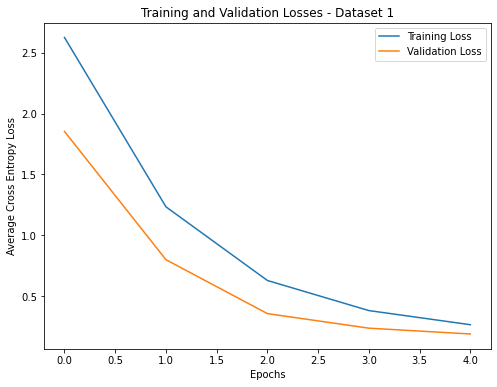

In [35]:
plt.figure(figsize=(8, 6))
plt.plot(model_train_loss_1, label='Training Loss')
plt.plot(model_val_loss_1, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Average Cross Entropy Loss')
plt.title('Training and Validation Losses - Dataset 1')
plt.savefig('loss_graph_custom_cnn.png')

## Plot epochs vs Training and Validation Accuracy for Dataset 1

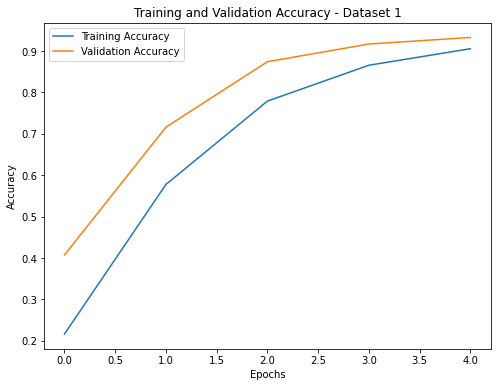

In [36]:
plt.figure(figsize=(8, 6))
plt.plot(model_train_acc_1, label='Training Accuracy')
plt.plot(model_val_acc_1, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy - Dataset 1')
plt.savefig('accuracy_graph_custom_cnn.png')

## Evaluate the model on testing set of Dataset 1

In [37]:
freq_list_test_1 = generate_freq_class_dataloader(dataloader_1['test'])

In [38]:
test_acc_1, test_loss_1, acc_every_class_1 = eval_model(dataloader_1['test'], test_dataloader_1_length, freq_list_test_1)

### Accuracy and Losses of model on testing set of Dataset 1

In [39]:
print(test_acc_1.item() * 100, test_loss_1)

93.11724137931034 0.18874369186094436


### Accuracy of every class of Dataset 1 by model on testing set of Dataset 1

In [40]:
print(acc_every_class_1 * 100)

[ 93.35106383  99.32795699  99.48914432  93.63395225  86.20689655
  97.79614325  91.39072848  98.95697523  96.09690444  96.02122016
  90.47619048  99.44211994  91.85082873  94.92656876  93.76657825
  94.66292135  98.82198953  99.33244326  88.19628647  91.64456233
  54.0397351   81.81818182  89.60709759  95.31680441  92.44791667
  98.78869448  97.90301442 100.          96.12724758]


## Evaluate the model on testing set of Dataset 2

In [41]:
freq_list_test_2 = generate_freq_class_dataloader(dataloader_2['test'])

In [42]:
test_acc_2, test_loss_2, acc_every_class_2 = eval_model(dataloader_2['test'], test_dataloader_2_length, freq_list_test_2)

### Accuracy and Losses of model on testing set of Dataset 2

In [43]:
print(test_acc_2.item() * 100, test_loss_2)

20.18348623853211 10.698657416422433


### Accuracy of every class of Dataset 1 by model on testing set of Dataset 2

In [44]:
print(acc_every_class_2 * 100)

[ 0.         14.28571429 18.18181818 20.          0.         16.66666667
 18.18181818 40.          0.         42.85714286  0.         62.5
  0.         60.         10.         16.66666667 25.         25.
  0.         10.          0.          0.         20.          0.
 36.36363636 57.14285714 60.         33.33333333  8.33333333]


## Train the pre-trained model for 5 epochs on Dataset 2

In [45]:
model, model_train_loss_2, model_train_acc_2, model_val_loss_2, model_val_acc_2 = train_model(model, dataloader_2['train'], train_dataloader_2_length, dataloader_2['val'], val_dataloader_2_length, criterion, optimizer, num_epochs, save_file_name_2)

Epoch 0
Training Loss - 4.21 Training Accuracy - 15.17%
Validation Loss - 3.0 Validation Accuracy - 16.13%
Time elapsed - 3.7 secs

Epoch 1
Training Loss - 2.53 Training Accuracy - 24.83%
Validation Loss - 2.13 Validation Accuracy - 35.48%
Time elapsed - 6.49 secs

Epoch 2
Training Loss - 1.87 Training Accuracy - 42.07%
Validation Loss - 1.86 Validation Accuracy - 41.94%
Time elapsed - 9.49 secs

Epoch 3
Training Loss - 1.53 Training Accuracy - 52.87%
Validation Loss - 1.65 Validation Accuracy - 45.16%
Time elapsed - 12.37 secs

Epoch 4
Training Loss - 1.24 Training Accuracy - 61.84%
Validation Loss - 1.72 Validation Accuracy - 47.0%
Time elapsed - 15.19 secs

Training Complete!
Best epoch - 3
Final Validation Loss - 1.6463
Final Validation Accuracy - 45.16%


## Plot epochs vs Training and Validation Losses for Dataset 2

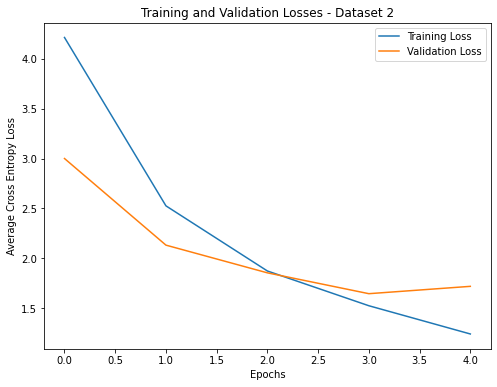

In [46]:
plt.figure(figsize=(8, 6))
plt.plot(model_train_loss_2, label='Training Loss')
plt.plot(model_val_loss_2, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Average Cross Entropy Loss')
plt.title('Training and Validation Losses - Dataset 2')
plt.savefig('loss_graph_custom_cnn_new_dataset.png')

## Plot epochs vs Training and Validation Accuracy for Dataset 2

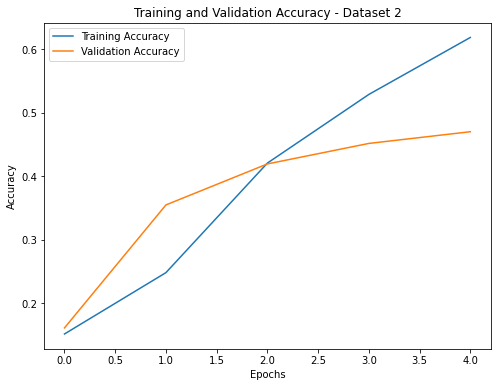

In [47]:
plt.figure(figsize=(8, 6))
plt.plot(model_train_acc_2, label='Training Accuracy')
plt.plot(model_val_acc_2, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy - Dataset 2')
plt.savefig('accuracy_graph_custom_cnn_new_dataset.png')

## Evaluate the model on testing set of Dataset 2

In [48]:
test_acc_2, test_loss_2, acc_every_class_2 = eval_model(dataloader_2['test'], test_dataloader_2_length, freq_list_test_2)

### Accuracy and Losses of model on testing set of Dataset 2

In [49]:
print(test_acc_2.item() * 100, test_loss_2)

55.04587155963303 1.4998650703955134


### Accuracy of every class of Dataset 2 by model on testing set of Dataset 2

In [50]:
print(acc_every_class_2 * 100)

[100.          42.85714286  54.54545455  80.          33.33333333
  16.66666667  54.54545455 100.          75.          71.42857143
  10.          50.          42.85714286  20.          50.
  50.          62.5         50.           0.          50.
  42.85714286  66.66666667  80.          44.44444444  81.81818182
 100.         100.          66.66666667  50.        ]
